# Logistic Regression(Application)

由于现在主流的DL框架是:Tensorflow,Pytorch,Keras.所以我们接下去的代码都基本会有4个版本

(1) 完全手写搭建代码(主要是为了深度去理解原理)

(2) 其他的我们都会使用框架再现一次,使得处理速度上更快,编写代码更加方便.

![](../picture/02.png)

![](../picture/08.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py

现在我们来看看个案例,将LR应用于图片分类中.构建"猫与非猫"的二元分类器
### 1 加载数据集
这个数据集是放在h5文件中的,所以我们需要使用库h5py将图片数据读取出来.

In [2]:
def load_data():
    '''
    create train set and test set
    make sure you have .h5 file in your dataset
    
    Returns:
    -------
        train_set_x_orig: original train set shape is (209, 64, 64, 3) 
        train_set_y_orig: original train label shape is (209,)
        test_set_x_orig: original test set shape is (50, 64, 64, 3)
        test_set_y_orig: original test label shape is (50,)
        classes: cat or non-cat.
        
    Note:
    ----
        (209, 64, 64, 3): 209 picture,64 width,64 height,3 channel.
    '''
    train_dataset = h5py.File('../data_set/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../data_set/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


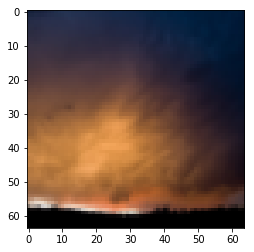

In [4]:
index = 0
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[index]) + ". It's a " + classes[train_y[index]].decode("utf-8") +  " picture.")

y = 1. It's a cat picture.


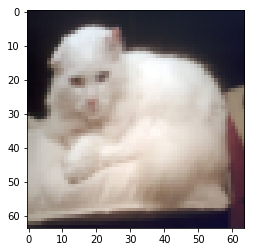

In [5]:
index = 13
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[index]) + ". It's a " + classes[train_y[index]].decode("utf-8") +  " picture.")

### 2 reshape picture

由于图片的原始数据是(m,width,height,channel)的形式,我们需要将其转换为(m,n)的形式,也就是说我们需要将channel的所有数字转换成一列.并除上255归一化.更多图片的学习,我们将在K-means算法中学习.

In [6]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1) / 255 
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1) / 255
print('Train_x\'s shape:{}'.format(train_x.shape))
print('Test_x\'s shape:{}'.format(test_x.shape))
print("Train_y's shape:{}".format(train_y.shape))
print("Test_y's shape:{}".format(test_y.shape))

Train_x's shape:(209, 12288)
Test_x's shape:(50, 12288)
Train_y's shape:(209,)
Test_y's shape:(50,)


### 3 initialization parameters

这里在初始化参数时需要有几个注意的地方:

(1) 参数$w,b$的初始值不可过大,这样会使得参数初始值处于sigmoid函数的平缓地带.所以我们会使用

```python
W = np.random.rand(1,n)```

(2) 我们需要设置随机种子,这样可以保证每次运行的初始结果是一样的.这样做的好处是:

我们在进行不同超级参数$\alpha,\lambda,Iter$调节的时候,不会因为初始值的改变而使得结果不可信.

In [7]:
def initial(n):
    """
    initialization parameters
    
    Returns:
    -------
        W:weights
        b:bias
    """
    np.random.seed(1)
    W = np.random.rand(1,n)
    b = np.zeros((1,1))
    
    return W,b

### 4 Sigmoid function

$\sigma(z)=\frac{1}{1+e^{-z}}$

In [8]:
def sigmoid(Z):
    return 1./(1. + np.exp(-Z))

### 5 Build LR

构建基本的Logistics Regression的时候,我们需要看看各个参数的维度以及损失函数

**参数维度:**

假设我们的训练样本$X$的维度是(m,n),标签的维度是(1,m)其中m:样本数量,n:特征数量

那么我们经过参数$W,b$预测出来的值记为$A$则:

$A$:(1,m)

$Z$:(1,m),因为$sigmoid(Z)$并不改变矩阵维度

$Z=WX+b$:所以我们令$W$的维度为(1,n),这样$(1,n)X(m,n)^{T} $可以得到(1,m).$b$为常数.


**Ps:**


- 其实这里的初始$W,b$维度可以不用这样令.无论是$W$转置还是$X$只要最后能得到(1,m)的形式就行,我这里这样令维度是对接神经网络,方便记忆.

- 特别地:在python中形状是(m,)就相当于维度(1,m)

- 因为Numpy的广播机制存在,所以$WX$得到的结果可以和一个常数相加


如果你发现在拟合过程中,无论怎样调节超级参数$learning rate,Iter,C$都无法出现很好的情况,那么除了[特征工程](https://www.zhihu.com/question/29316149)之外,你就需要考虑正则化.

其中C是惩罚项,就是我们正则化式子中的$\lambda$


(1) $L_1$ Regular:$loss(W) = -[Ylog(\hat{Y})+(1-Y)log(1-\hat{Y})] + \lambda {||W||}_1$

(2) $L_1$ Regular:$loss(W) = -[Ylog(\hat{Y})+(1-Y)log(1-\hat{Y})] + \frac{\lambda}{2} {||W||}_2$

In [9]:
def LR_Regular(X_train,y_train,alpha,Iter,C,is_print,Regular_method='l2'):
    """
    Implementation Regularization of LR
    
    Prameters:
    ---------
        X_train: training set.
        y_train: labels
        alpha: learning
        Iter:number of iterative
        C: regularization strength
        is_print: is print loss value
        Regular_method: l1 or l2,default l2
    Return:
    ------
        W:Weights
        b:bias
        cost: loss value
    """
    m,n = X_train.shape
    W,b = initial(n)
    
    cost = []
    
    for iter_ in range(Iter):
        
        Z = np.dot(W,X_train.T) + b
        A = sigmoid(Z)
        
        if Regular_method =="l2":
            loss = - (np.sum((y_train*np.log(A)+(1-y_train)*np.log(1-A))) + (C/2)*np.sum(W**2))/m
        elif Regular_method=="l1":
            loss = - (np.sum((y_train*np.log(A)+(1-y_train)*np.log(1-A))) + C*np.sum(W))/m
        
        cost.append(loss)
        if is_print and iter_ % 100 ==0:
            print("Iter:{},loss:{}".format(iter_,loss))
            
        dZ = A - y_train
        
        dW = np.dot(dZ,X_train)/m
        
        assert dW.shape == W.shape # Make sure the shape is right.
        
        db = np.sum(dZ,keepdims=True) /m
        
        assert db.shape == b.shape
        
        if Regular_method =="l2": 
            W = W - alpha * (dW + C * W)
            b = b - alpha * db
        elif Regular_method =="l1": 
            W = W - alpha * (dW + C * np.sign(W))
            b = b - alpha * db

    return W,b,cost

In [10]:
W_img,b_img,cost_img = LR_Regular(train_x,train_y,0.01,1100,0,True,'l2')

Iter:0,loss:nan
Iter:100,loss:nan


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


Iter:200,loss:nan
Iter:300,loss:nan
Iter:400,loss:inf
Iter:500,loss:2.337086145864673
Iter:600,loss:1.0534926584987783
Iter:700,loss:0.6529591365207578
Iter:800,loss:0.4572399153459881
Iter:900,loss:0.3497704251041613
Iter:1000,loss:0.28251280899529285


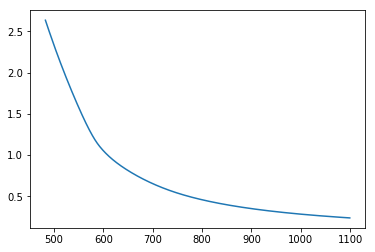

In [11]:
plt.plot(cost_img)

可以看出,损失随着迭代是在逐渐减小的,另外在迭代的过程中出现了"nan","inf"是因为出现了上下溢的问题:

- 数值上溢:大量级的数被近似为正无穷或负无穷时发生上溢,进一步运算导致无限值变为非数字.
- 数值下溢:接近零的数被四舍五入为0时发生下溢.被零除,取零的对数，进一步运算会变为非数字.

这里先不任何处理,与本节内容无太大关系.在后面我们会详细来解决这个问题.

### 6 Build Predict function

现在构建预测函数,并且返回正确率.

另外我们说过,在sigmoid函数中如果值大于0.5,我们将其分为第一类,小于0.5我们可以将其分为第二类.

所以我们可以使用四舍五入函数

```python

np.round(A)```

In [12]:
def Predict(X_test,y_test,W,b):
    """
    Predict labels.
    
    Prameters:
    ----------
        X_test:testing set
        y_test:labels
        W:weights
        b:bias
        
    Return:
    ------
        correct_rate: correct rate.
    
    """
    Z = np.dot(W,X_test.T) + b
    A = sigmoid(Z)
    
    predict_y = np.round(A) 
    
    correct_rate = np.sum((predict_y==y_test))/y_test.shape[0]
    
    return correct_rate

In [13]:
correct_rate = Predict(test_x,test_y,W_img,b_img)
print('The test ste correct rate is:',correct_rate)

The test ste correct rate is: 0.72


In [14]:
correct_rate = Predict(train_x,train_y,W_img,b_img)
print('The train ste correct rate is:',correct_rate)

The train ste correct rate is: 0.937799043062201


# Summary

由于这里我们只是使用最简单的LR回归,所以效果肯定是很差的,在以后随着网络适当的加深,效果会逐渐变好,此Application只是为了做一个概念铺垫,其中$Z,A$的步骤可以称之为正向传播(Forward propagation),而参数链式法则可以称之为反向传播(backward propagation),计算损失函数和梯度可以称之为优化器(optimizater).